# Week 9: Dropout

In [ ]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

First, load in MNIST and display a character:

Image Size: (1, 28, 28)


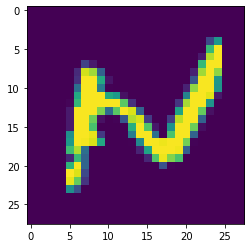

In [ ]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].squeeze().moveaxis(0, -1))

In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


In [ ]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [ ]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [ ]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [ ]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [512,512,512] # this should be an array with units per hidden layer
num_classes = 10 

vnn = VanillaNN(dataset[0][0].squeeze().shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [ ]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 10 
lr = 1e-3 

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [ ]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/10, Iter: 100/480, Loss: 1.5903
Epoch: 1/10, Iter: 200/480, Loss: 1.5776
Epoch: 1/10, Iter: 300/480, Loss: 1.5615
Epoch: 1/10, Iter: 400/480, Loss: 1.5500
Epoch: 1/10, Iter: 480/480, Loss: 1.5273
Epoch 1 Train Accuracy: 93.45%
Epoch 1 Test Accuracy: 93.08%

Epoch: 2/10, Iter: 100/480, Loss: 1.5270
Epoch: 2/10, Iter: 200/480, Loss: 1.4841
Epoch: 2/10, Iter: 300/480, Loss: 1.5458
Epoch: 2/10, Iter: 400/480, Loss: 1.5109
Epoch: 2/10, Iter: 480/480, Loss: 1.5118
Epoch 2 Train Accuracy: 94.40%
Epoch 2 Test Accuracy: 93.49%

Epoch: 3/10, Iter: 100/480, Loss: 1.4904
Epoch: 3/10, Iter: 200/480, Loss: 1.4621
Epoch: 3/10, Iter: 300/480, Loss: 1.4957
Epoch: 3/10, Iter: 400/480, Loss: 1.5051
Epoch: 3/10, Iter: 480/480, Loss: 1.5004
Epoch 3 Train Accuracy: 95.60%
Epoch 3 Test Accuracy: 94.97%

Epoch: 4/10, Iter: 100/480, Loss: 1.4984
Epoch: 4/10, Iter: 200/480, Loss: 1.4970
Epoch: 4/10, Iter: 300/480, Loss: 1.5012
Epoch: 4/10, Iter: 400/480, Loss: 1.5217
Epoch: 4/10, Iter: 480/480, Loss: 1

In [ ]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 95.24%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**
Without enforcing a rule that some number of nodes must be activated, there are 2^n possible networks.  

**TODO: How does dropout change the relationship of units in the network with their neighbors?**
One unit cannot depend absolutely on the input of a neighboring unit. Therefore, features must become more robust to noise, and identify more generalized trends in the data. 


In [ ]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(0.5),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(0.5),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(0.5),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [ ]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [512,512,512]
dropout_probs = [0.5,0.5,0.5]
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [ ]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 10 
lr2 = 1e-3 

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [ ]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/10, Iter: 100/480, Loss: 1.7497
Epoch: 1/10, Iter: 200/480, Loss: 1.6287
Epoch: 1/10, Iter: 300/480, Loss: 1.6064
Epoch: 1/10, Iter: 400/480, Loss: 1.6433
Epoch: 1/10, Iter: 480/480, Loss: 1.6222
Epoch 1 Train Accuracy: 90.55%
Epoch 1 Test Accuracy: 90.12%

Epoch: 2/10, Iter: 100/480, Loss: 1.6438
Epoch: 2/10, Iter: 200/480, Loss: 1.5642
Epoch: 2/10, Iter: 300/480, Loss: 1.5624
Epoch: 2/10, Iter: 400/480, Loss: 1.5492
Epoch: 2/10, Iter: 480/480, Loss: 1.6489
Epoch 2 Train Accuracy: 93.32%
Epoch 2 Test Accuracy: 93.05%

Epoch: 3/10, Iter: 100/480, Loss: 1.6079
Epoch: 3/10, Iter: 200/480, Loss: 1.5986
Epoch: 3/10, Iter: 300/480, Loss: 1.6475
Epoch: 3/10, Iter: 400/480, Loss: 1.5777
Epoch: 3/10, Iter: 480/480, Loss: 1.6068
Epoch 3 Train Accuracy: 92.59%
Epoch 3 Test Accuracy: 92.33%

Epoch: 4/10, Iter: 100/480, Loss: 1.5891
Epoch: 4/10, Iter: 200/480, Loss: 1.5516
Epoch: 4/10, Iter: 300/480, Loss: 1.5721
Epoch: 4/10, Iter: 400/480, Loss: 1.5194
Epoch: 4/10, Iter: 480/480, Loss: 1

In [ ]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 93.63%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**

The model actually converged more slowly than with the vanilla model.  

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [ ]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

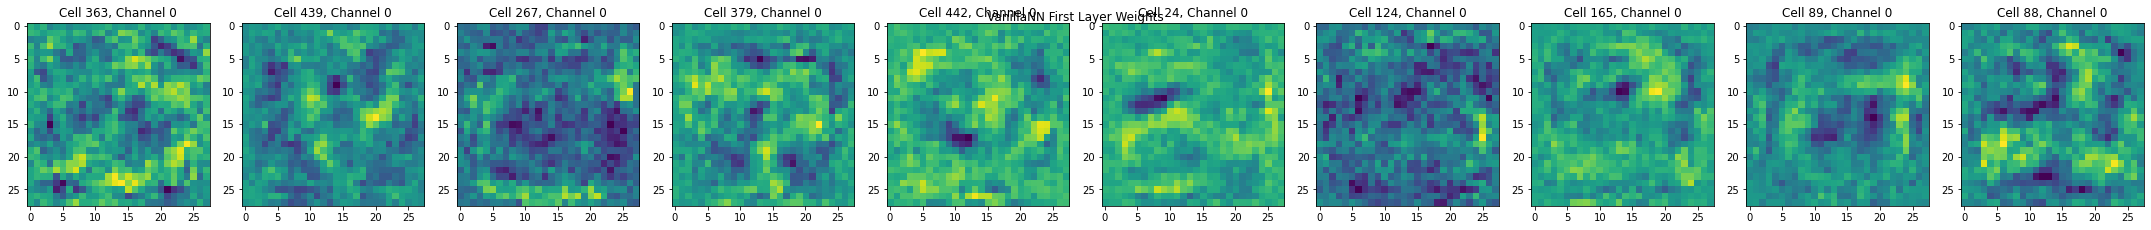

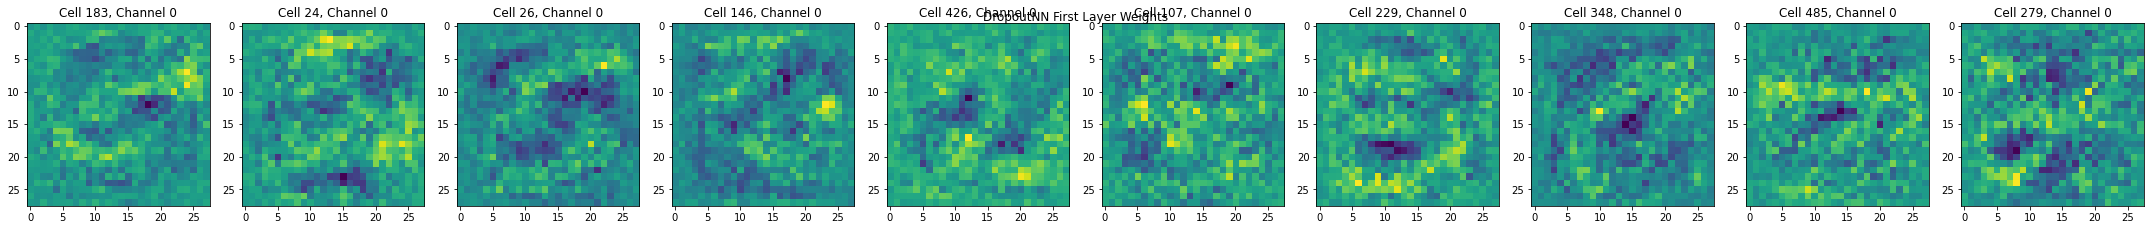

In [ ]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**

I would argue that the dropout layers yield more coherent "latent images" than the vanilla network. I may be primed to think this, but I feel like I can see more interpretable impressions of actual digits in the dropout layers. This supports the notion that the learned features represent more general patterns than the vanilla network. 

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [ ]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

In [ ]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

In [41]:
%matplotlib notebook 
vanilla_res

<IPython.core.display.Javascript object>

In [45]:
%matplotlib inline
dropout_res

<IPython.core.display.Javascript object>

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**
The differences are slight, but I would contend that the dropout networks have more well defined regions in the features, with less "static noise," than do the vanilla features. This scould be interpreted as the dropout not being as sensitive to variance in individual pixels, but once again picking up more on general features. Furthermore, the random switching on/off of pixels would ensure that features develop robustness to the presence or absence of an individual pixel, as the model would would not perform well if easily perturbable by the absence of a pixel. Therefore, the iomages that maximize features will be comprised of general patterns, not the summation of individual pixels from potentially disparate regions. 

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**
Unfortunately, I have not been successful in coercing my instance of the notebook into actually showing the final figures, and so have been unable to experiment with visualizing different layers (my answer to the previous question was based on the figures that were visible in the answer key. Instead, I will speculate that early layers of the dropout network will have more simple, familiar patterns and shapes. On the other hand, I imagine that early layers of the vanilla network will also tend toward simpler shapes, but with much more diffuse noise/static than in the dropout network layers.  

